# Time Series Modeling

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from random import gauss as gs
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
%matplotlib inline

## White Noise

The idea behind white noise is that it is truly random.

We don't want white noise to describe our model per se, but we *do* want it to describe our model *error*.

Can you explain these truisms?

In [4]:
# Let's make some white noise!

rands = []
for _ in range(1000):
    rands.append(gs(0, 1))
series = pd.Series(rands)

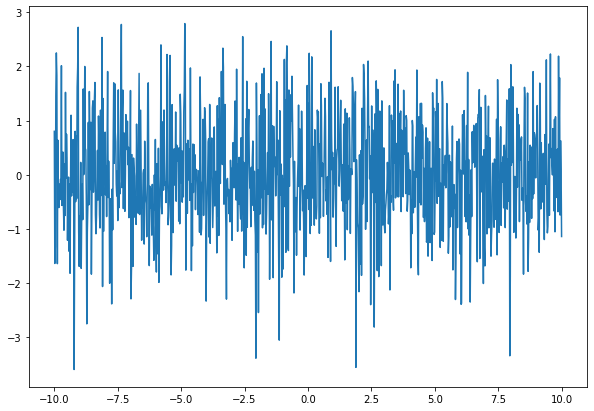

In [5]:
X = np.linspace(-10, 10, 1000)
plt.figure(figsize=(10, 7))
plt.plot(X, series);

What happens if we do a seasonal decomposition on this?

In [6]:
series.index[:5]

RangeIndex(start=0, stop=5, step=1)

In [7]:
time_index = pd.to_datetime(series.index, unit='D')

In [8]:
time_index[:5]

DatetimeIndex(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04',
               '1970-01-05'],
              dtype='datetime64[ns]', freq=None)

In [25]:
series.index = time_index
decomp_white = sm.tsa.seasonal_decompose(fb)

In [26]:
series

1970-01-01    0.801846
1970-01-02   -1.636099
1970-01-03   -1.325823
1970-01-04    1.457360
1970-01-05    2.248442
                ...   
1972-09-22    1.789477
1972-09-23   -0.742336
1972-09-24    0.629528
1972-09-25    0.095020
1972-09-26   -1.138819
Length: 1000, dtype: float64

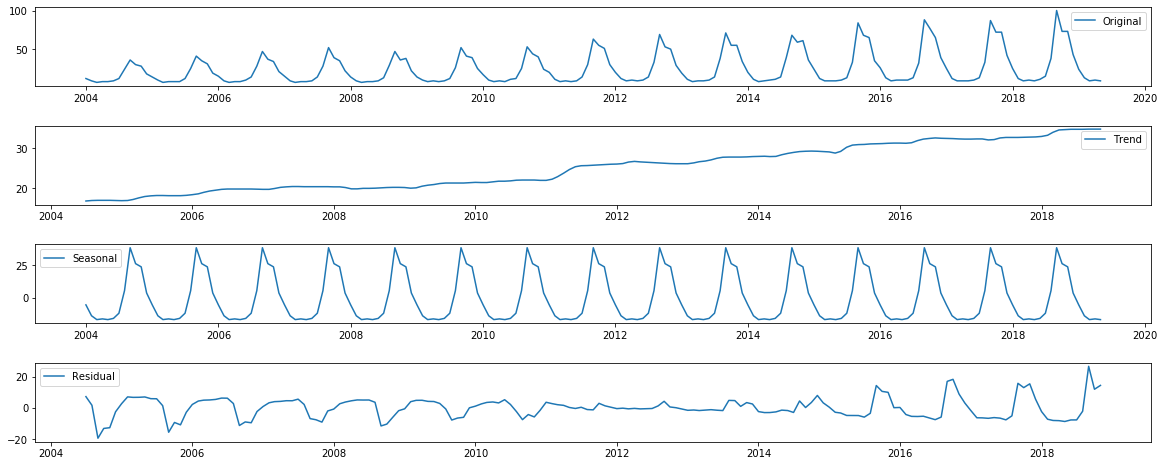

In [28]:
plt.figure(figsize=(20, 8))
plt.subplot(411)
plt.plot(fb.index, decomp_white.observed, label='Original')
plt.legend()
plt.subplot(412)
plt.plot(fb.index, decomp_white.trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(fb.index, decomp_white.seasonal, label='Seasonal')
plt.legend()
plt.subplot(414)
plt.plot(fb.index, decomp_white.resid, label='Residual')
plt.legend()
plt.subplots_adjust(hspace=0.5);

## Football Data

In [16]:
fb = pd.read_csv('data/google-trends_football_us.csv').iloc[1:, :]
fb.columns = ['counts']

In [17]:
fb['counts'] = fb['counts'].replace('<1', '0')
fb['counts'] = fb['counts'].astype(int)

In [23]:
fb.index = pd.to_datetime(fb.index.tolist())

In [24]:
fb.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01'],
              dtype='datetime64[ns]', length=185, freq=None)

### Series as Both Predictor and Target?

Often, the phenomenon we want to capture with a time series is a dataset being correlated with *itself*.

Well, of course every dataset is perfectly correlated with itself. But what we're after now is the idea that a series is correlated with *earlier versions* of itself.

Consider the problem of trying to predict tomorrow's closing price for some stock on the market. One may consider lots of features, like what sort of company it is to which the stock belongs or whether that company has been in the news recently.

But it is very often the case that one of the most helpful predictors of tomorrow's price is *today's* price. And so we want to build a model where one of our predictors is an earlier version of our target.

One tool we can use is **`df.rolling()`**, which creates a Rolling object that we can use to calculate statistics dynamically.

In [ ]:
fb.rolling()

In [ ]:
fb.head(10)

In [ ]:
type(fb.rolling(window=1))

In [ ]:
fb.rolling(window=3).mean()

In [ ]:
fb['roll_avg'] = fb.rolling(window=2).mean()

fb.corr()

In [ ]:
fb['roll_avg'].head()

In [ ]:
plt.plot(fb.index[:30], fb['counts'][:30])
plt.plot(fb.index[1:31], fb['roll_avg'][1:31])

plt.xticks(rotation = 90);

In [ ]:
lr = LinearRegression()

lr.fit(fb[['roll_avg']][1:], fb['counts'][1:])

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(fb.index[1:25], fb['counts'][1:25], label='Data')
plt.plot(fb.index[1:25], lr.predict(fb[['roll_avg']][1:25]),
         label='Predicted')
plt.legend();

### Autocorrelation and Partial Autocorrelation Functions

Pandas and statsmodels offer autocorrelation (ACF) and partial autocorrelation (PACF) plotting tools. The idea here is to look at the correlation of a series with itself for some particular interval or *lag*. The key difference between the full and the partial autocorrelation functions is that the partial autocorrelation function ignores intervening intervals. For more, see [this post](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/).

#### Autocorrelation

The basic idea of autocorrelation is simple: See how a series correlates with a "lagged" version of itself. If my sequence is $S_0 = (x_0, x_1, x_2, ... , x_n)$, then I can measure the Pearson correlation between the first $n-k + 1$ terms of $S_0$ and $S_{lag} = (x_k, x_{k+1}, x_{k+2}, ... , x_n)$.

In [29]:
acf(fb['counts'], nlags=20, fft=False)

array([ 1.        ,  0.75835271,  0.39614692, -0.02682356, -0.33671769,
       -0.51430013, -0.57433698, -0.50805221, -0.33213019, -0.03322244,
        0.35934472,  0.6897616 ,  0.9007188 ,  0.68924357,  0.35742731,
       -0.03006143, -0.31578315, -0.47909837, -0.53500615, -0.47438158,
       -0.31460724])

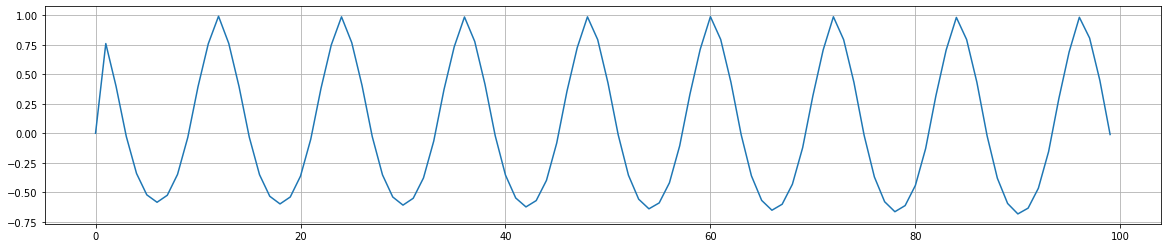

In [30]:
# Plot using `.autocorr()`

X = np.arange(0, 100, 1)
Y = np.zeros(100)
for j in X[1:]:
    Y[j] = fb['counts'].autocorr(lag=j)
plt.figure(figsize=(20, 4))
plt.plot(X, Y)
plt.grid();

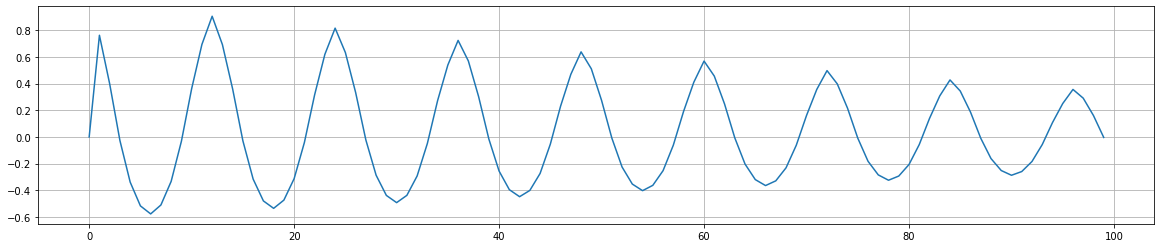

In [31]:
# To construct the autocorrelation function, we take the covariance of our time series with a lagged version
# and then divide by the variance of the series.

X = np.arange(0, 100, 1)
Y = np.zeros(100)
for j in X[1:]:
    Y[j] += np.cov(fb['counts'][:-j], fb['counts'][j:])[0, 1] / np.var(fb['counts']) * ((180-j) / 180)
plt.figure(figsize=(20, 4))
plt.plot(X, Y)
plt.grid();

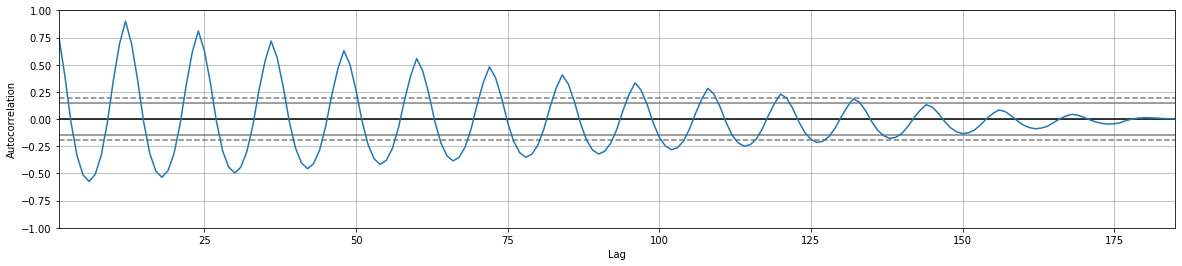

In [32]:
plt.figure(figsize=(20, 4))
pd.plotting.autocorrelation_plot(fb['counts']);

The horizontal bands represent condfidence intervals, which are calculated by taking relevant z-scores of the standard normal distribution and dividing by the square root of the number of observations. For more, see [here](https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm).

Calculation of the 95%-confidence interval:

In [33]:
stats.norm().ppf(0.975) / np.sqrt(fb['counts'].shape[0])

0.14409941802110895

Calculation of the 99%-confidence interval:

In [35]:
stats.norm().ppf(0.995) / np.sqrt(fb['counts'].shape[0])

0.18937873679868608

We can also use the `plot_acf()` function from statsmodels:

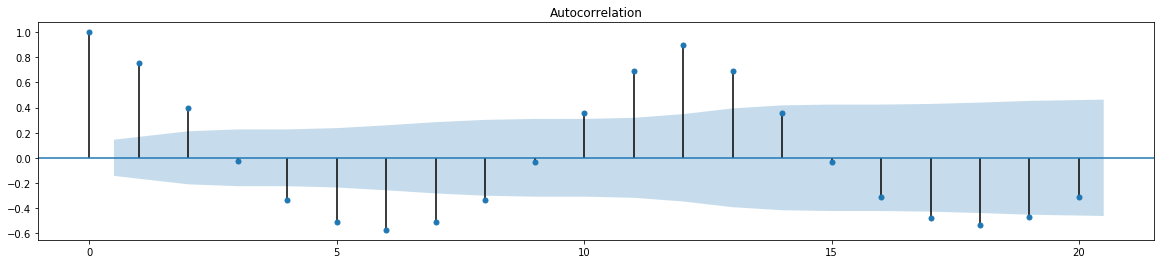

In [36]:
rcParams['figure.figsize'] = 20, 4

plot_acf(fb['counts'], lags=20, alpha=0.05);

#### Partial Autocorrelation

The idea behind partial Autocorrelation is to compare a series to a lagged version of itself while abstracting away from intermediate values. In effect, this amounts to exploring the correlations among *residuals*.

In [37]:
pacf(fb['counts'], nlags=20)

array([ 1.        ,  0.76247419, -0.43209792, -0.39679619, -0.05921461,
       -0.13159449, -0.25344002, -0.09844008,  0.01124303,  0.2226528 ,
        0.47869494,  0.40442703,  0.78649095, -0.62389408, -0.02531833,
        0.24143533, -0.06033339, -0.01474157, -0.03507918, -0.04910669,
        0.00738705])

##### Calculation #1

One way of computing the partial autocorrelation is by fitting regressions to residuals from a simple dummy model that always predicts the mean. The coefficient of the final term will be the partial autocorrelation for the corresponding number of lags.

In [38]:
y_tilde = fb['counts'] - fb['counts'].mean()

In [39]:
x_1 = (fb['counts'][:-1] - fb['counts'].mean()).values.reshape(-1, 1)
x_2 = (fb['counts'][:-2] - fb['counts'].mean()).values.reshape(-1, 1)

In [40]:
lr = LinearRegression()

lr.fit(np.concatenate([x_1[1:], x_2], axis=1), y_tilde[2:]).coef_[-1]

-0.42286729591663597

In [41]:
x_1 = (fb['counts'][:-1] - fb['counts'].mean()).values.reshape(-1, 1)
x_2 = (fb['counts'][:-2] - fb['counts'].mean()).values.reshape(-1, 1)
x_3 = (fb['counts'][:-3] - fb['counts'].mean()).values.reshape(-1, 1)

In [42]:
lr2 = LinearRegression()

lr2.fit(np.concatenate([x_1[2:], x_2[1:], x_3], axis=1), y_tilde[3:]).coef_[-1]

-0.3855304642823899

##### Calculation #2

An alternative way of calculating these values is to solve the matrix equation:

$\begin{bmatrix}
\rho(0) & ... & \rho(k-1) \\
... & ... & ... \\
\rho(k-1) & ... & \rho(0)
\end{bmatrix}
\begin{bmatrix}
\phi_{k1} \\
... \\
\phi_{kk}
\end{bmatrix} = \begin{bmatrix}
\rho(1) \\
... \\
\rho(k)
\end{bmatrix}$,

where $\rho(k)$ is the autocorrelation for $k$ lags.

In [43]:
row1 = acf(fb['counts'], nlags=1, fft=False)
row2 = acf(fb['counts'], nlags=1, fft=False)[::-1]

autos = np.vstack([row1, row2])
autos

array([[1.        , 0.75835271],
       [0.75835271, 1.        ]])

In [44]:
b = acf(fb['counts'], nlags=2, fft=False)[1:]

In [45]:
np.linalg.solve(autos, b)[-1]

-0.42116124886935863

For more on this method, see [this post](https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula).

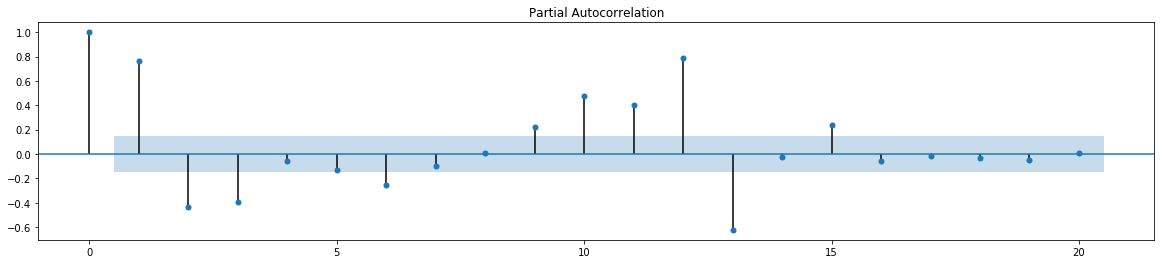

In [46]:
rcParams['figure.figsize'] = 20, 4

plot_pacf(fb['counts'], lags=20, alpha=0.05);

For more on ACF and PACF, see [these slides](http://people.cs.pitt.edu/~milos/courses/cs3750/lectures/class16.pdf) and [this post](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8).

## ARMA Modeling

- 'AR' is for "**Auto-Regressive**": The prediction for today will be a function of the value for previous days.

    The number of lag periods we want to include will be a parameter in the statsmodels model object ("p").

    In particular, auto-regressive models look like this:

    $X_t = \beta_0 + \Sigma^p_{i=1}\beta_iX_{t-i} + \epsilon_t$, <br/>
    where $\epsilon_t$ should be more or less accurately modeled by white noise.

    We indicate how many terms our $AR$ model has by writing $AR(k)$ where $k$ is the number of terms.

    Looking at the PACF can help us decide on an appropriate $p$: We can look at where the correlation values cross the confidence thresholds. <br/><br/>

- 'MA' is for "**Moving Average**": The prediction for today will be a function of the rolling mean.

    The number of average terms we want to include will be a parameter in the statsmodels model object ("q").

    In  particular, moving-average models look like this:

    $X_t = \mu + \epsilon_t + \Sigma^q_{i=1}\beta_i\epsilon_{t-i}$, <br/>
    where again the $\epsilon$ should be modeled by white noise.

    We indicate how many terms our $MA$ model has by writing $MA(k)$ where $k$ is the number of terms.

    Looking at the ACF can help us decide on an appropriate $q$: We can look at where the correlation values cross the confidence thresholds.

For some technical details, see [this page](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model#Choosing_p_and_q).

The $AR$ and $MA$ models are intimately related. In fact $AR(p)$ is equivalent to $MA(\infty)$ for any $p$. The reverse holds as well if $|\theta| < 1$ for all $\theta$ in $MA(q)$. For more on this, see [here](https://otexts.com/fpp2/MA.html).

Consider $AR(1)$:

$X_t = \beta_0 + \beta_1X_{t-1} + \epsilon_t$ <br/> 
$= \beta_0 + \beta_1(\beta_1X_{t-2} + \epsilon_{t-1})$ <br/>
$= \beta_0 + \beta_1^2X_{t-2} + \beta_1\epsilon_{t-1}$ <br/>
$= \beta_0 + \beta_1^3X_{t-3} + \beta_1^2\epsilon_{t-2} + \beta_1\epsilon_{t-1}$

In the limit of this expansion we obtain an expression for $MA(\infty)$.

### Stationarity and the Dickey-Fuller Test

ARMA models assume that the time series is *stationary*, which means that its statistical properties are not a (meaningful) function of time.

It may seem counterintuitive that, for modeling purposes, we want our time series not to be a function of time! But the basic idea is the familiar one that we want our datapoints to be mutually *independent*. For more on this topic, see [here](https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary).

One way of testing for stationarity is to use the Dickey-Fuller Test. The statsmodels version returns the test statistic and a p-value, relative to the null hypothesis that the series in question is NOT stationary. For more, see [this Wikipedia page](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test).

In [ ]:
# Presumably, our football series is not stationary. Let's check.

adfuller(fb['counts'], autolag=None)

But let's check the stationarity of the *differences* of our data. We'll use **`.diff()`**:

In [ ]:
fb['counts'].head()

In [ ]:
fb['counts'].diff().head()

In [ ]:
adfuller(fb['counts'].diff()[1:], autolag= None)

### Building the Model

In [48]:
from statsmodels.tsa.arima_model import ARMA


In [57]:
p = 1
q = 3

# This model will have three auto-regressive terms and one moving-average term.

ar = ARMA(fb['counts'].diff().values[1:], (p, q)).fit()

In [58]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  184
Model:                     ARMA(1, 3)   Log Likelihood                -717.719
Method:                       css-mle   S.D. of innovations             11.832
Date:                Fri, 24 Apr 2020   AIC                           1447.439
Time:                        14:40:57   BIC                           1466.729
Sample:                             0   HQIC                          1455.257
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0974      0.059      1.664      0.096      -0.017       0.212
ar.L1.y        0.4790      0.085      5.666      0.000       0.313       0.645
ma.L1.y       -0.5304      0.079     -6.733      0.000      -0.685      -0.376
ma.L2.y       -0.0171      0.102     -0.167      0.868      -0.218       0.183
ma.L3.y       -0.4526      0.081     -5.617      0.000      -0.610      -0.295
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0877           +0.0000j            2.0877            0.0000
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.5189           -1.3930j            1.4865           -0.3067
MA.3           -0.5189           +1.3930j            1.4865            0.3067
-----------------------------------------------------------------------------
"""

In [59]:
np.sqrt(mean_squared_error(fb['counts'].diff().values[1:], ar.predict()))

11.89270649829278

In [60]:
r2_score(fb['counts'].diff().values[1:], ar.predict())

0.30883743945770936

#### `np.cumsum()`
Let's use `np.cumsum()` to add up our predictions!

In [ ]:
fb['counts'].head()

In [ ]:
np.cumsum(fb['counts']).head()

In [ ]:
preds = ar.predict()
full = fb['counts'].values[0] +  np.cumsum(preds)

f, a = plt.subplots(figsize=(20, 4))
a.plot(fb.index[1:], fb['counts'][1:], 'r', label='Data')
a.plot(fb.index[1:-1], full[1:], 'k', label='Fit')
plt.legend();

In [ ]:
f, a = plt.subplots(figsize=(20, 4))
a.plot(fb.index[1:], fb['counts'].diff()[1:], label='Data')
a.plot(fb.index[1:-1], preds[1:], label='Fit')
plt.legend();

### Unemployment Data

In [61]:
data = pd.read_csv('data/seasonally-adjusted-quarterly-us.csv')

In [62]:
data.head()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


In [63]:
data.columns = ['year_q', 'unemp_rate']
data['unemp_rate'] = data['unemp_rate'].map(lambda x:\
                                            float(str(x).replace('%', '')))
data.dropna(inplace=True)

In [64]:
data['date'] = pd.to_datetime(data['year_q']).dt.to_period('Q')
data.set_index('date', inplace=True, drop=True)

In [65]:
data.head()

,year_q,unemp_rate
date,,
1948Q1,1948Q1,3.733
1948Q2,1948Q2,3.667
1948Q3,1948Q3,3.767
1948Q4,1948Q4,3.833
1949Q1,1949Q1,4.667


In [72]:
p=4
q=0
ar2 = ARMA(data['unemp_rate'].diff()[1:].values, (p, q)).fit()

In [73]:
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  173
Model:                     ARMA(4, 0)   Log Likelihood                 -48.456
Method:                       css-mle   S.D. of innovations              0.319
Date:                Fri, 24 Apr 2020   AIC                            108.911
Time:                        14:43:24   BIC                            127.831
Sample:                             0   HQIC                           116.587
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0147      0.040      0.364      0.716      -0.065       0.094
ar.L1.y        0.7244      0.075      9.653      0.000       0.577       0.872
ar.L2.y       -0.1329      0.093     -1.422      0.155      -0.316       0.050
ar.L3.y       -0.0586      0.094     -0.625      0.532      -0.242       0.125
ar.L4.y       -0.1357      0.076     -1.779      0.075      -0.285       0.014
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0356           -0.7424j            1.2742           -0.0990
AR.2            1.0356           +0.7424j            1.2742            0.0990
AR.3           -1.2515           -1.7245j            2.1308           -0.3499
AR.4           -1.2515           +1.7245j            2.1308            0.3499
-----------------------------------------------------------------------------
"""

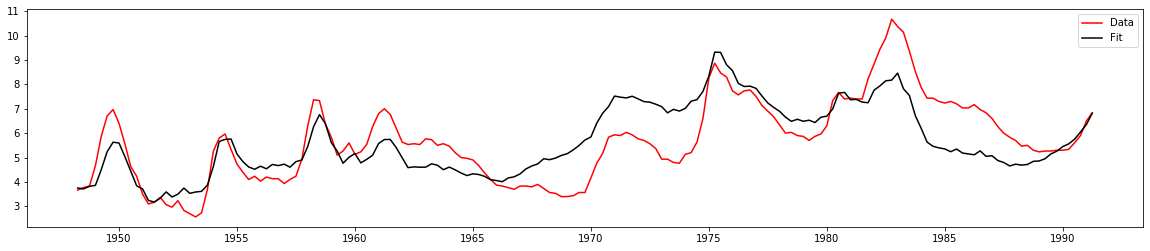

In [69]:
preds2 = ar2.predict()
full2 = data['unemp_rate'].values[0] + np.cumsum(preds2)

f, a = plt.subplots(figsize=(20, 4))
a.plot(data.index.to_timestamp()[1:], data['unemp_rate'][1:],
       'r', label='Data')
a.plot(data.index.to_timestamp()[1:], full2, 'k', label='Fit')
plt.legend();

In [ ]:
data['unemp_rate'][-5:]

In [ ]:
# `.forecast()`: Let's check out the doc here.

ar2.forecast(steps=3)

In [ ]:
data['unemp_rate'].tail()

In [ ]:
data['unemp_rate'].head()

In [ ]:
data.head()

In [ ]:
data['unemp_rate'][-1]

In [ ]:
data['unemp_rate'][-1] + np.cumsum(ar2.forecast(steps=3)[0])

In [ ]:
f, a = plt.subplots(figsize=(20, 4))
a.plot(data.index.to_timestamp()[1:], data['unemp_rate'].diff()[1:],
       label='Data')
a.plot(data.index.to_timestamp()[1:], preds2, label='Fit')
plt.legend();

### ARMA $\rightarrow$ ARIMA $\rightarrow$ SARIMA $\rightarrow$ SARIMAX

This idea of using the *differences* of our data points to make our data stationary and so appropriate for ARMA modeling is encoded in **ARIMA** modeling. The 'I' is for "integrated". **SARIMA** modeling adds a **S**easonal component. And **SARIMAX** modeling adds e**X**ogenous (independent) variables.

Statsmodels supports these models as well:

In [75]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


#### Let's see if we can do a better job with our football data by including a seasonal component.

In [82]:
season_model = SARIMAX(fb['counts'], order=(3, 1, 1), seasonal_order= (1,1,1,12)).fit()

season_model.summary()

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             counts   No. Observations:                  185
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -420.763
Date:                            Fri, 24 Apr 2020   AIC                            855.527
Time:                                    14:46:36   BIC                            877.559
Sample:                                01-01-2004   HQIC                           864.466
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3801      0.073      5.188      0.000       0.237       0.524
ar.L2         -0.0276      0.118     -0.234      0.815      -0.259       0.204
ar.L3         -0.0106      0.117     -0.091      0.928      -0.239       0.218
ma.L1         -0.9999      4.729     -0.211      0.833     -10.268       8.268
ar.S.L12       0.0431      2.394      0.018      0.986      -4.648       4.735
ma.S.L12      -0.0758      2.403     -0.032      0.975      -4.786       4.634
sigma2         7.6017     35.512      0.214      0.831     -62.000      77.203
===================================================================================
Ljung-Box (Q):                       58.96   Jarque-Bera (JB):               746.85
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               3.99   Skew:                             2.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
season_model.predict()

2004-01-01     0.000000
2004-02-01    11.999980
2004-03-01     9.000001
2004-04-01     7.000007
2004-05-01     8.000001
                ...    
2019-01-01    26.259857
2019-02-01    12.444280
2019-03-01    10.264767
2019-04-01    10.815102
2019-05-01     9.860820
Freq: MS, Length: 185, dtype: float64

In [84]:
fb['counts']

2004-01-01    12
2004-02-01     9
2004-03-01     7
2004-04-01     8
2004-05-01     8
              ..
2019-01-01    24
2019-02-01    13
2019-03-01     9
2019-04-01    10
2019-05-01     9
Name: counts, Length: 185, dtype: int64

In [85]:
np.sqrt(mean_squared_error(fb['counts'], season_model.predict()))

3.3056751593066993

Is this worse than before? Or not?

In [86]:
r2_score(fb['counts'], season_model.predict())

0.9743365335706542

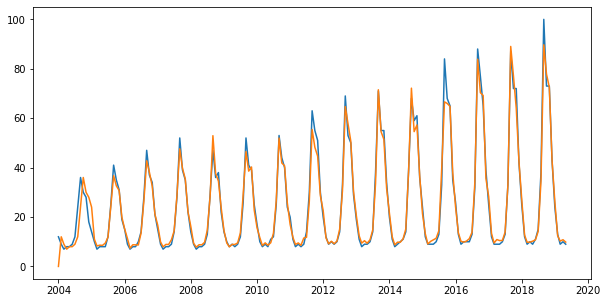

In [87]:
f, a = plt.subplots(figsize=(10, 5))

a.plot(fb.index, fb['counts'])
a.plot(fb.index, season_model.predict());

# Resources

- [Forecasting Principles and Practice](https://otexts.com/fpp2/MA.html)

- [Upenn - Stats510 - Applied Time Series Analysis](https://online.stat.psu.edu/stat510/)

- [UPenn - Stats501 - Regression Methods](https://online.stat.psu.edu/stat501/lesson/14)

- [Full online course on Time Series Analysis](https://www.youtube.com/playlist?list=PLtiTxpFJ4k6TZ0g496fVcQpt_-XJRNkbi)

- [Another online lecture series for Time Series Analysis- Georgia Tech](https://www.youtube.com/watch?v=31ng0uLqfhc&list=PL_onPhFCkVQghJC-KQkUNvkAGbriARyfX)